In [2]:
import pandas as pd
import numpy as np

In [3]:
metadata = pd.read_csv('./../../../leafsnap-dataset-30subset/leafsnap-dataset-30subset-images.txt', delimiter='\t')

In [ ]:
metadata

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [5]:
transform = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop(128),
                                transforms.ToTensor()])
images_root = './../../../leafsnap-dataset-30subset/dataset/images/lab/Auto_cropped/'
dataset = datasets.ImageFolder(images_root, transform=transform)

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)



In [7]:
images, labels = next(iter(dataloader))

In [9]:
!setx KMP_DUPLICATE_LIB_OK 'TRUE'


SUCCESS: Specified value was saved.


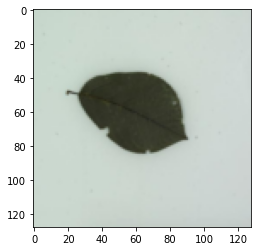

In [18]:
im = np.array(images[1].permute(1,2,0))
plt.imshow(im)

In [19]:
labels[:10]

tensor([10, 21, 13, 22,  7, 16,  7, 22,  0, 15])

In [22]:
dataset.classes[labels[0]]

'chionanthus_virginicus'

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*16*16, 30)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()